<a href="https://colab.research.google.com/github/mihirn07/CS726_project/blob/main/WGAN_GP_withouBN_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Loading Libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import torch
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import torch.utils.data as data
from torch.utils.data import DataLoader
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data.distributed import DistributedSampler
from torch.utils.data import sampler
import torchvision.datasets as dset
from torch.autograd import Variable

import os
import time
from google.colab.patches import cv2_imshow
import pickle
import cv2
import numpy as np
import glob
from PIL import Image
import shutil

from skimage.color import rgb2lab, lab2rgb, rgb2gray, xyz2lab
from skimage.io import imsave

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torchsummary import summary

from itertools import product
from math import sqrt

dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available()==False:
  dtype=torch.FloatTensor
print(device,dtype)

cuda <class 'torch.cuda.FloatTensor'>


Setting configuration

In [42]:
class set_config:

  def __init__(self):
    self.cuda=torch.cuda.is_available()
    self.weight_decay=0 
    self.lr=4e-5 
    self.test_img_name=None 
    self.batch_size=25
    self.mode='train'
    self.resume = True

    try:
      self.save_path=glob.glob('/content/drive/MyDrive/CS726_proj/weights/*')[0]
    except:
      self.save_path=glob.glob('/content/drive/MyDrive/CS726_proj/weights/*')

    self.dir='/content/drive/MyDrive/CS726_proj/'
    self.lamb=100
    self.epoch = 2
    self.lambd = 10

config=set_config()
print(config.save_path)

/content/drive/MyDrive/CS726_proj/weights/latest_colorize_weights_9.pth.tar


Generator Model

In [5]:
class Generator(nn.Module):

    def __init__(self):
      super(Generator,self).__init__()
      self.conv1=nn.Conv2d(1,64,3,stride=1,padding=1,bias=False)
      self.relu1=nn.LeakyReLU(0.2)

      self.conv2=nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
      self.bn2=nn.BatchNorm2d(64,momentum=0.5)
      self.relu2=nn.LeakyReLU(0.2)
      
      self.conv3=nn.Conv2d(64,128,3,stride=2,padding=1,bias=False)
      self.bn3=nn.BatchNorm2d(128,momentum=0.5)
      self.relu3=nn.LeakyReLU(0.2)

      self.conv4=nn.Conv2d(128,256,3,stride=2,padding=1,bias=False)
      self.bn4=nn.BatchNorm2d(256,momentum=0.5)
      self.relu4=nn.LeakyReLU(0.2)

      self.conv5=nn.Conv2d(256,512,3,stride=2,padding=1,bias=False)
      self.bn5=nn.BatchNorm2d(512,momentum=0.5)
      self.relu5=nn.LeakyReLU(0.2)

      self.conv6=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn6=nn.BatchNorm2d(512,momentum=0.5)
      self.relu6=nn.LeakyReLU(0.2)

      self.conv7=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn7=nn.BatchNorm2d(512,momentum=0.5)
      self.relu7=nn.LeakyReLU(0.2)

      self.conv8=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.bn8=nn.BatchNorm2d(512,momentum=0.5)
      self.relu8=nn.LeakyReLU(0.2)

      self.conv9=nn.ConvTranspose2d(512,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn9=nn.BatchNorm2d(512,momentum=0.5)
      self.relu9=nn.ReLU()
      
      self.conv10=nn.ConvTranspose2d(1024,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn10=nn.BatchNorm2d(512,momentum=0.5)
      self.relu10=nn.ReLU()

      self.conv11=nn.ConvTranspose2d(1024,512,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn11=nn.BatchNorm2d(512,momentum=0.5)
      self.relu11=nn.ReLU()

      self.conv12=nn.ConvTranspose2d(1024,256,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn12=nn.BatchNorm2d(256,momentum=0.5)
      self.relu12=nn.ReLU()

      self.conv13=nn.ConvTranspose2d(512,128,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn13=nn.BatchNorm2d(128,momentum=0.5)
      self.relu13=nn.ReLU()

      self.conv14=nn.ConvTranspose2d(256,64,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn14=nn.BatchNorm2d(64,momentum=0.5)
      self.relu14=nn.ReLU()

      self.conv15=nn.ConvTranspose2d(128,64,3,stride=2,padding=1,output_padding=1,bias=False)
      self.bn15=nn.BatchNorm2d(64,momentum=0.5)
      self.relu15=nn.ReLU()
      
      self.conv16=nn.Conv2d(128,3,1,stride=1,bias=False)

    def forward(self,img):
      
      x1=self.relu1(self.conv1(img))

      x2=self.relu2(self.bn2(self.conv2(x1)))

      x3=self.relu3(self.bn3(self.conv3(x2)))

      x4=self.relu4(self.bn4(self.conv4(x3)))

      x5=self.relu5(self.bn5(self.conv5(x4)))

      x6=self.relu6(self.bn6(self.conv6(x5)))

      x7=self.relu7(self.bn7(self.conv7(x6)))

      x8=self.relu8(self.bn8(self.conv8(x7)))

      x9=self.relu9(self.bn9(self.conv9(x8)))
      x9=torch.cat([x7,x9],1)

      x10=self.relu10(self.bn10(self.conv10(x9)))
      x10=torch.cat([x6,x10],1)

      x11=self.relu11(self.bn11(self.conv11(x10)))
      x11=torch.cat([x5,x11],1)

      x12=self.relu12(self.bn12(self.conv12(x11)))
      x12=torch.cat([x4,x12],1)

      x13=self.relu13(self.bn13(self.conv13(x12)))
      x13=torch.cat([x3,x13],1)

      x14=self.relu14(self.bn14(self.conv14(x13)))
      x14=torch.cat([x2,x14],1)

      x15=self.relu15(self.bn15(self.conv15(x14)))
      x15=torch.cat([x1,x15],1)

      x16=self.conv16(x15)
      x16=torch.tanh(x16)

      return x16
    
    def init_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()

Discriminator Model

In [6]:
class Critic(nn.Module):

    def __init__(self):
      super(Critic,self).__init__()
      
      self.conv1=nn.Conv2d(3,64,3,stride=1,padding=1,bias=False)
      self.relu1=nn.LeakyReLU(0.2)

      self.conv2=nn.Conv2d(64,64,3,stride=2,padding=1,bias=False)
      self.relu2=nn.LeakyReLU(0.2)

      self.conv3=nn.Conv2d(64,128,3,stride=2,padding=1,bias=False)
      self.relu3=nn.LeakyReLU(0.2)

      self.conv4=nn.Conv2d(128,256,3,stride=2,padding=1,bias=False)
      self.relu4=nn.LeakyReLU(0.2)

      self.conv5=nn.Conv2d(256,512,3,stride=2,padding=1,bias=False)
      self.relu5=nn.LeakyReLU(0.2)

      self.conv6=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.relu6=nn.LeakyReLU(0.2)

      self.conv7=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.relu7=nn.LeakyReLU(0.2)

      self.conv8=nn.Conv2d(512,512,3,stride=2,padding=1,bias=False)
      self.relu8=nn.LeakyReLU(0.2)

      self.flat=nn.Flatten()
      self.fc1=nn.Linear(2048,100)
      self.relu9=nn.LeakyReLU(0.2)
      self.fc2=nn.Linear(100,1)
    
    def forward(self,img):

      x1=self.relu1(self.conv1(img))

      x2=self.relu2(self.conv2(x1))

      x3=self.relu3(self.conv3(x2))

      x4=self.relu4(self.conv4(x3))

      x5=self.relu5(self.conv5(x4))

      x6=self.relu6(self.conv6(x5))

      x7=self.relu7(self.conv7(x6))

      x8=self.relu8(self.conv8(x7))

      x8=self.flat(x8)

      x9=self.relu9(self.fc1(x8))

      x10=torch.sigmoid(self.fc2(x9))

      return x10
    
    def init_weights(self):

      for name,module in self.named_modules():
        if isinstance(module,nn.Conv2d) or isinstance(module,nn.ConvTranspose2d):
          nn.init.xavier_uniform_(module.weight.data)
          if module.bias is not None:
            module.bias.data.zero_()
        if isinstance(module,nn.Linear):
          nn.init.xavier_uniform_(module.weight.data)

##Load Dataset

In [6]:
import requests 
url = 'http://data.csail.mit.edu/places/places365/val_256.tar'
target_path = '/content/drive/MyDrive/CS726_proj/val_256.tar'

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(target_path, 'wb') as f:
        f.write(response.raw.read())

KeyboardInterrupt: ignored

In [8]:
shutil.unpack_archive('/content/drive/MyDrive/CS726_proj/val_256.tar',"/content/drive/MyDrive/CS726_proj/data/")

In [9]:
import os

arr = os.listdir('/content/drive/MyDrive/CS726_proj/data/val_256/')
arr

['Places365_val_00035900.jpg',
 'Places365_val_00035572.jpg',
 'Places365_val_00002949.jpg',
 'Places365_val_00007265.jpg',
 'Places365_val_00019005.jpg',
 'Places365_val_00027775.jpg',
 'Places365_val_00015062.jpg',
 'Places365_val_00014185.jpg',
 'Places365_val_00026692.jpg',
 'Places365_val_00006857.jpg',
 'Places365_val_00006425.jpg',
 'Places365_val_00034332.jpg',
 'Places365_val_00014622.jpg',
 'Places365_val_00026135.jpg',
 'Places365_val_00018645.jpg',
 'Places365_val_00006382.jpg',
 'Places365_val_00034495.jpg',
 'Places365_val_00017090.jpg',
 'Places365_val_00009925.jpg',
 'Places365_val_00009557.jpg',
 'Places365_val_00025787.jpg',
 'Places365_val_00005530.jpg',
 'Places365_val_00005942.jpg',
 'Places365_val_00032579.jpg',
 'Places365_val_00017737.jpg',
 'Places365_val_00025020.jpg',
 'Places365_val_00012069.jpg',
 'Places365_val_00005297.jpg',
 'Places365_val_00029047.jpg',
 'Places365_val_00036467.jpg',
 'Places365_val_00033339.jpg',
 'Places365_val_00004370.jpg',
 'Places

In [10]:
len(arr)

36500

In [11]:
arr[0]

'Places365_val_00035900.jpg'

In [12]:
import os
import shutil

for i in range(5000):
  os.replace('/content/drive/MyDrive/CS726_proj/data/val_256/'+arr[i], '/content/drive/MyDrive/CS726_proj/data/train/'+arr[i])

In [13]:
import os
import shutil

for i in range(6700,6750):
  os.replace('/content/drive/MyDrive/CS726_proj/data/val_256/'+arr[i], '/content/drive/MyDrive/CS726_proj/test_imgs/'+arr[i])

##DataLoader

In [7]:
class Places365Loader(data.Dataset):

    def __init__(self,mode='train'):
      
      self.mode=mode
      self.cfg=config
      self.data_root='/content/drive/MyDrive/CS726_proj/data/'
      if self.mode=='train':
        self.data_path=self.data_root+'train/*.*'
        self.img_path_list=glob.glob(self.data_path)
      
      elif self.mode=='test':
        self.data_path=config.dir+'test_imgs/*.*'
        self.img_path_list = glob.glob(self.data_path)

    def __getitem__(self,index):

      if self.mode=='test':
        image=cv2.imread(self.img_path_list[index])
        lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        lab_image= cv2.cvtColor(lab_image, cv2.COLOR_RGB2LAB)
        lab_image=lab_image.astype(np.float64)
        lab_image/=255.0
        lab_image=torch.from_numpy(lab_image.transpose(2,0,1))
        l_image=lab_image[0,:,:].unsqueeze(0)
        c_image=lab_image[1:,:,:]
        mean=torch.Tensor([0.5])
        l_image=l_image-mean.expand_as(l_image)
        c_image=c_image-mean.expand_as(c_image)
        l_image=2*l_image
        c_image=2*c_image
        gray_image=l_image
        lab_image=torch.cat([l_image,c_image],0)
        image=torch.from_numpy(image.transpose(2,0,1))
        return lab_image,gray_image,image

      if self.mode=='train':
        image=cv2.imread(self.img_path_list[index])
        lab_image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        lab_image= cv2.cvtColor(lab_image, cv2.COLOR_RGB2LAB)
        lab_image=lab_image.astype(np.float64)
        lab_image/=255.0
        lab_image=torch.from_numpy(lab_image.transpose(2,0,1))
        l_image=lab_image[0,:,:].unsqueeze(0)
        c_image=lab_image[1:,:,:]
        mean=torch.Tensor([0.5])
        l_image=l_image-mean.expand_as(l_image)
        c_image=c_image-mean.expand_as(c_image)
        l_image=2*l_image
        c_image=2*c_image
        gray_image=l_image
        lab_image=torch.cat([l_image,c_image],0)
        image=torch.from_numpy(image.transpose(2,0,1))
        return lab_image,gray_image,image
    
    def __len__(self):

      if self.mode=='test':
        return len(self.img_path_list)
      else:
        return len(self.img_path_list)

#Collate Functions

In [8]:
def train_collate(batch):

  lab_list,gray_list,img_list=[],[],[]
  for i,sample in enumerate(batch):
    lab_list.append(sample[0])
    gray_list.append(sample[1])
    img_list.append(sample[2])
  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)
  imgs=torch.stack(img_list)
  return lab_imgs,gray_imgs,imgs

def test_collate(batch):

  lab_list,gray_list,img_list=[],[],[]
  for i,sample in enumerate(batch):
    lab_list.append(sample[0])
    gray_list.append(sample[1])
    img_list.append(sample[2])
  lab_imgs=torch.stack(lab_list)
  gray_imgs=torch.stack(gray_list)
  imgs=torch.stack(img_list)
  return lab_imgs,gray_imgs,imgs

##DeProcessing Functions

In [9]:
def imlabshow(img,mode='train',name=None):
  npimg=img.cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  plt.imshow(np_rgb_img)
  plt.show()
  '''if mode=='test':
    np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_Original',np_rgb_img)'''

  #np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
  #cv2_imshow(np_rgb_img)

def imfakeshow(img,mode='train',name=None):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  plt.imshow(np_rgb_img)
  plt.show()
  '''if mode=='test':
    np_rgb_img=cv2.cvtColor(np_rgb_img,cv2.COLOR_RGB2BGR)
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_Fake',np_rgb_img)'''

def imgrayshow(img,mode='train',name=None):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 + 0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  cv2_imshow(np_lab_img)
  '''if mode=='test':
    cv2.imwrite(config.dir+'dataset/test/results/'+name+'_GrayScale',np_lab_img)'''

def imrealshow(img,mode='train',name=None):
  npimg=img.detach().cpu().numpy()
  npimg=npimg/2 +0.5
  np_lab_img=npimg.transpose(1,2,0)
  np_lab_img*=255
  np_rgb_img=cv2.cvtColor(np_lab_img.astype(np.uint8), cv2.COLOR_LAB2RGB)
  plt.imshow(np_rgb_img)
  plt.show()

##Saving Weights and Loss History

In [10]:
def save_weights(state,step_no):
  weight=glob.glob(config.dir+'weights/latest*')
  assert len(weight)<=1, "Multiple weights file, delete others."
  if weight:
    os.remove(weight[0])
  print("Saving weights as latest_colorize_weights_"+str(step_no))
  torch.save(state,config.dir+"weights/latest_colorize_weights_"+str(step_no)+".pth.tar")

def save_loss_hist(loss_d,loss_g):
  loss_g_hist=glob.glob(config.dir+'Gen_loss_*')
  loss_d_hist=glob.glob(config.dir+'Dis_loss_*')
  assert len(loss_g_hist)<=1, "Multiple files of Gen History"
  assert len(loss_d_hist)<=1, "Multiple files of Dis History"
  if loss_g_hist:
    os.remove(loss_g_hist[0])
  if loss_d_hist:
    os.remove(loss_d_hist[0])
  open_file = open(config.dir+"Gen_loss_hist.pkl", "wb")
  pickle.dump(loss_g, open_file)
  open_file.close()
  open_file = open(config.dir+"Dis_loss_hist.pkl", "wb")
  pickle.dump(loss_d, open_file)
  open_file.close()

##Preparing for Training, Loading Pre-existing Resumed State

In [43]:
Gen_Model=Generator().cuda()
Cri_Model=Critic().cuda()
Gen_Model.train()
Cri_Model.train()

dataset= Places365Loader(config.mode)
optimizer_G=optim.RMSprop(Gen_Model.parameters(),lr=config.lr)
optimizer_C=optim.RMSprop(Cri_Model.parameters(),lr=config.lr)
train_loader=DataLoader(dataset,config.batch_size,shuffle=True,collate_fn=train_collate)
loss_g=[]
loss_c=[]
if config.resume:
  checkpoint=torch.load(config.save_path)
  Gen_Model.load_state_dict(checkpoint['state_dict_G'])
  Cri_Model.load_state_dict(checkpoint['state_dict_D'])
  optimizer_G.load_state_dict(checkpoint['optimizer_G'])
  optimizer_C.load_state_dict(checkpoint['optimizer_D'])
  open_file=open(config.dir+'Gen_loss_hist.pkl','rb')
  loss_g=pickle.load(open_file)
  open_file.close()
  open_file=open(config.dir+'Dis_loss_hist.pkl','rb')
  loss_c=pickle.load(open_file)
  open_file.close()
  print(f'\nResume training with \'{config.save_path}\'.\n')
else:
  Gen_Model.init_weights()
  Cri_Model.init_weights()


Resume training with '/content/drive/MyDrive/CS726_proj/weights/latest_colorize_weights_9.pth.tar'.



In [34]:
def calc_gradient_penalty(Cri_Model, real_data, fake_data):
  alpha = torch.rand(config.batch_size,1)
  alpha = alpha.expand(config.batch_size,int(real_data.nelement()/config.batch_size)).contiguous().view(config.batch_size, 3, 256, 256)
  alpha = alpha.cuda()

  interpolates = alpha*real_data + (1-alpha)*fake_data
  interpolates = interpolates.cuda()
  interpolates = Variable(interpolates, requires_grad = True)
  disc_interpolates = Cri_Model(interpolates)

  gradients = torch.autograd.grad(outputs=disc_interpolates, inputs=interpolates,grad_outputs=torch.ones(disc_interpolates.size()).cuda(),create_graph=True, retain_graph=True, only_inputs=True)[0]

  gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean() * (config.lambd)

  return gradient_penalty

In [35]:
def train_critic(optimizer, real_data, fake_data,c=0.01):
    optimizer.zero_grad()
    error_real = Cri_Model(real_data).mean()
    error_fake = Cri_Model(fake_data).mean()
    gradient_penalty = calc_gradient_penalty(Cri_Model, real_data, fake_data) 
    total_error = -(error_real - error_fake) + gradient_penalty
    total_error.backward()

    optimizer.step()
    for p in Cri_Model.parameters():
        p.data.clamp_(-c, c)
    total_error = np.array(total_error.detach().cpu())
    return -total_error

def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    error = -Cri_Model(fake_data).mean()
    return error

##Computing Loss & Training the Model

In [44]:
torch.autograd.set_detect_anomaly(True)
step=1
if config.resume:
  step=checkpoint['step']+1
training=True
real_label=0.9
fake_label=0.0
time_last=time.time()

n_critic = 5
y = []

while step<config.epoch:
  for i,(lab_imgs,gray_imgs,imgs) in enumerate(train_loader):
      
      lab_imgs=Variable(lab_imgs.cuda().type(dtype))
      gray_imgs=Variable(gray_imgs.cuda().type(dtype))

      imgs=Variable(imgs.cuda().type(dtype))

      fake_data = Gen_Model(gray_imgs).detach()
      real_data = imgs.to(device)
      errorC = train_critic(optimizer_C, real_data, fake_data)
      loss_c.append(errorC)
        
      if (i+1)%n_critic==0:
          fake_data = Gen_Model(gray_imgs)
          L1=nn.L1Loss()
          error_G_L1=L1(fake_data.view(fake_data.size(0),-1),lab_imgs.view(lab_imgs.size(0),-1))
          errorG = train_generator(optimizer_G, fake_data) + config.lamb * error_G_L1
          errorG.backward()
          optimizer_G.step()
          errorG = np.array(errorG.detach().cpu())
          loss_g.append(errorG)
      this_time=time.time()

      if i%20==0:
        print("Batch No -",i,"Completed with time",this_time-time_last)
        with torch.no_grad():
          imfakeshow(fake_data[0])
      time_last=time.time()

  print("Epoch ",step," done")
  state={'step':step,
         'state_dict_G':Gen_Model.state_dict(),
         'state_dict_D':Cri_Model.state_dict(),
         'optimizer_G':optimizer_G.state_dict(),
         'optimizer_D':optimizer_C.state_dict()}


  save_weights(state,step)
  save_loss_hist(loss_c,loss_g)

  plt.plot(np.array(loss_c), 'r')
  plt.xlabel('No. of batch')
  plt.ylabel('Discriminator Loss')
  plt.grid()
  plt.show()

  plt.plot(np.array(loss_g), 'b')
  plt.xlabel('No. of batch')
  plt.ylabel('Generator Loss')
  plt.grid()
  plt.show()

  step+=1

In [45]:
step

10

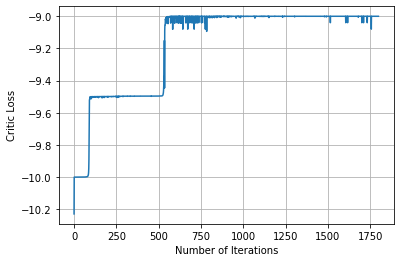

In [37]:
plt.plot(np.array(loss_c))
plt.ylabel("Critic Loss")
plt.xlabel("Number of Iterations")
plt.grid()

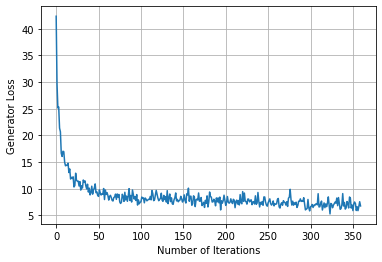

In [38]:
plt.plot(np.array(loss_g))
plt.ylabel("Generator Loss")
plt.xlabel("Number of Iterations")
plt.grid()

##Model Testing & Metric Evaluation

In [39]:
################# Test Time ######################
#test_size = 1000;
model=Generator().to(device)
model.eval()
checkpoint=torch.load(config.save_path, map_location=torch.device('cpu'))
model.load_state_dict(checkpoint['state_dict_G'])

generated_imgs = []
real_imgs = []
bw_imgs = []
Lab_imgs = []

with torch.no_grad():
    test_data=Places365Loader('test')
    test_loader=DataLoader(test_data,config.batch_size,shuffle=False,collate_fn=test_collate)
    for i,(lab_imgs,gray_imgs,imgs) in enumerate(test_loader):
      lab_imgs=lab_imgs.cuda().type(dtype)
      gray_imgs=gray_imgs.cuda().type(dtype)
      imgs=imgs.cuda().type(dtype)
      fake_img=Gen_Model(gray_imgs)

      fake_img = fake_img.detach().cpu()
      lab_imgs = lab_imgs.detach().cpu()
      gray_imgs = gray_imgs.detach().cpu()
      imgs = imgs.detach().cpu()

      generated_imgs.append(fake_img)
      real_imgs.append(imgs)
      bw_imgs.append(gray_imgs)
      Lab_imgs.append(lab_imgs)

In [40]:
lis_generated_imgs = []
lis_real_imgs = []
lis_bw_imgs = []
lis_lab_imgs = []
for i in range(len(generated_imgs)):
  for j in range(generated_imgs[i].shape[0]):
    lis_generated_imgs.append(np.array(generated_imgs[i])[j])
    lis_real_imgs.append(np.array(real_imgs[i])[j])
    lis_bw_imgs.append(np.array(bw_imgs[i])[j])
    lis_lab_imgs.append(np.array(Lab_imgs[i])[j])

In [41]:
from math import log10, sqrt
from sklearn.metrics import mean_absolute_error
def eval_metric(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * log10(max_pixel / sqrt(mse))
    mae = mean_absolute_error(original.reshape((256*3,256)),compressed.reshape((256*3,256)))
    return psnr,mae

In [46]:
PSNR_metric_wgan_gp = []
MAE_metric_wgan_gp = []
for i in range(len(lis_generated_imgs)):
  original = lis_real_imgs[i]
  generated = lis_generated_imgs[i]
  psnr,mae = eval_metric(original,generated)
  PSNR_metric_wgan_gp.append(psnr)
  MAE_metric_wgan_gp.append(mae) 

In [47]:
print('PSNR metric is', sum(PSNR_metric_wgan_gp)/len(PSNR_metric_wgan_gp))
print('MAE metric is', sum(MAE_metric_wgan_gp)/len(MAE_metric_wgan_gp))

PSNR metric is 6.293512126333192
MAE metric is 110.6908854675293


In [48]:
def show_results(i,lis_generated_imgs,lis_real_imgs,lis_bw_imgs):
  print("GrayScale Image - ")
  imgrayshow(torch.tensor(lis_bw_imgs[i]))
  print("Original Image - ")
  imlabshow(torch.tensor(lis_lab_imgs[i]))
  print("Model Output Image - ")
  imfakeshow(torch.tensor(lis_generated_imgs[i]))

GrayScale Image - 


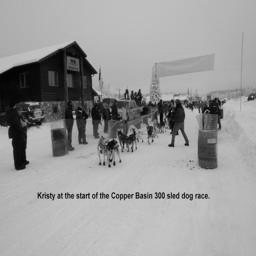

Original Image - 


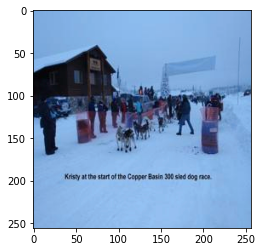

Model Output Image - 


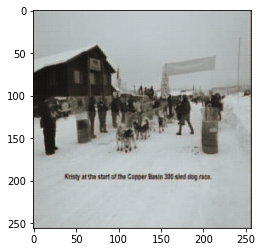

In [61]:
show_results(3,lis_generated_imgs,lis_real_imgs,lis_bw_imgs)